In [1]:
# Function to decode operation

In [1]:
%pylab inline 

import mne
from mne.datasets import spm_face
from mne.decoding import GeneralizationAcrossTime
import sys
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
from scipy import stats
#Add personal functions to python path
#sys.path.append('/Users/pinheirochagas/Pedro/NeuroSpin/Experiments/Calc_MEG/scripts/decoding/')
sys.path.append('/neurospin/meg/meg_tmp/Calculation_Pedro_2014/data/decoding/')
from fldtrp2mne import fldtrp2mne
from calc_twoClassClassify import calc_twoClassClassify
from sklearn import svm
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import StratifiedKFold

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Directories
data_path = '/neurospin/meg/meg_tmp/Calculation_Pedro_2014/data/mat/'
result_path = '/neurospin/meg/meg_tmp/Calculation_Pedro_2014/data/decoding/'
#data_path = '/Volumes/NeuroSpin2T/Calculation_Pedro_2014/data/mat/'
#result_path = '/Volumes/NeuroSpin2T/Calculation_Pedro_2014/data/decoding/'

#Subjects
#subjects = ['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09', 's10', 
           # 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18','s19', 's21', 's22']

subjects = ['s01']


#General parameters
baseline = (-0.5, -0.05)
downsmpDec = 4

#Decoding
trainset = 'all'
testset = 'all'
decCond = ['correct', 'incorrect']

params = {'baseline': baseline, 'downsmpDec': downsmpDec, 
'Classification': decCond, 'trainset': trainset, 'testset': testset}

#Results initialization
all_scores = []
all_diagonals = []

In [4]:
for sub in subjects:
    fname = op.join(data_path, sub + '_calc.mat') 
    epoch = fldtrp2mne(fname, 'data')

    #Baseline-correct & filter data
    print('Baseline-correcting data for subject: ' + sub)
    epoch.apply_baseline(baseline)
    
    #Load condition/behavior info
    matfile = sio.loadmat(fname)
    print('Loading trialinfo for subject: ' + sub)   
    trialinfo = matfile['data']['trialinfo']    
    operator = trialinfo[0][0][0][0][2].T
    operand1 = trialinfo[0][0][0][0][1].T
    absdeviant = trialinfo[0][0][0][0][8].T
    
    # Merge back and define conditions
    info = pd.DataFrame(data = np.concatenate((operator, operand1,absdeviant), axis = 1), 
                        columns = ['operation', 'operand1', 'absdeviant'])

    info['absdeviant'][info['absdeviant'] != 0] = 1
    
    correct = info['absdeviant'] == 0
    incorrect = info['absdeviant'] == 1
    add_sub = info['operation'] != 0
    
    condA = correct
    condB = incorrect
    
    stop
    #Sanity check #1: Plot evoked response
    evoked_condA = epoch[condA].average() # addition
    evoked_condB = epoch[condB].average() # subtraction
    evoked = evoked_condA - evoked_condB
    
    evoked_condA.plot(titles = decCond[0] + ' for subject: ' + sub, show = False)
    evoked_condB.plot(titles = decCond[1] + ' for subject: ' + sub, show = False)
    evoked.plot(titles = decCond[0] + ' - ' + decCond[1] + ' for subject: ' + sub, show = False)
    plt.show()

    
    #Sanity check #2: Plot GFP
    gfp_condA = np.median(np.std(epoch[condA]._data, axis = 1), axis = 0) #do I need to make sure that the number of trials is similar in the two conditions?
    gfp_condB = np.median(np.std(epoch[condB]._data, axis = 1), axis = 0)
    
    plt.plot(epoch.times, gfp_condA, color = 'g', label = decCond[0])
    plt.plot(epoch.times, gfp_condB, color = 'r', label = decCond[1])
    plt.axvline(0, color = 'k') #mark stimulus onset
    plt.legend(loc = 'lower right')
    plt.xlabel('Time (s)')
    plt.ylabel('GFP')
    plt.title('GFP for subject: ' + sub)
    plt.show()
    
    # Decoding
    epochs = epoch[add_sub] #select only target-present trials
    info = info[add_sub]
    y = np.array(info['absdeviant']) #select labels for the conditions
    y = y.astype(numpy.float64)
    # Downsampling for decoding
    epochs.decimate(downsmpDec)
    
    print('Decoding subject: ' + sub)
    gat, score, diagonal = calc_twoClassClassify(epochs, y, [], [], params)
    gat.plot()
    gat.plot_diagonal()  # plot decoding across time (correspond to GAT diagonal)

    #Store scores of different subjects in the same list
    all_scores.append(score)
    all_diagonals.append(diagonal)
    
#Transform into a numpy array   
all_scores = np.array(all_scores)
all_diagonals = np.array(all_diagonals)

# Save individual results
fname = op.join(result_path, 'Classification_ ' + decCond[0] + '_vs_' +
decCond[1] + '_Trainset_' + trainset + '_Testset_' + testset) 
np.save(fname, all_scores)

# Compute group averages
group_scores = np.mean(all_scores, 0)
sem_group_scores = stats.sem(all_scores, 0)

group_diagonal = np.mean(all_diagonals, 0)
sem_group_diagonal = stats.sem(all_diagonals, 0)

Baseline-correcting data for subject: s01
Applying baseline correction ... (mode: mean)
Loading trialinfo for subject: s01


NameError: name 'stop' is not defined

In [6]:
y = np.array(info['absdeviant']) #select labels for the conditions


In [15]:
size(epoch.times)


epoch.times

1251

In [10]:
epochs_new = epoch.crop(tmin=None, tmax=None, copy=False)

array([-0.5  , -0.496, -0.492, ...,  4.492,  4.496,  4.5  ])

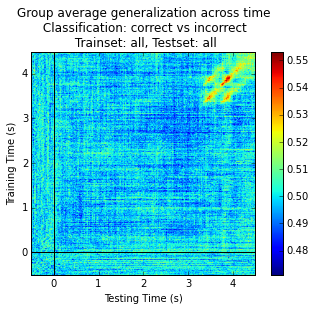

In [60]:
# Plotting  

# Plot GAT
plt.imshow(group_scores, origin = 'lower', extent = [epochs.times[0], epochs.times[len(epochs.times)-1], 
                                                     epochs.times[0], epochs.times[len(epochs.times)-1]]) #flip the matrix around
plt.axvline(0, color = 'k') #mark stimulus onset
plt.axhline(0, color = 'k') #mark stimulus onset
plt.colorbar()
plt.xlabel('Testing Time (s)')
plt.ylabel('Training Time (s)')
plt.title('Group average generalization across time \n Classification: ' + decCond[0] + ' vs ' 
+ decCond[1] + '\n Trainset: ' + trainset + ', Testset: ' + testset)



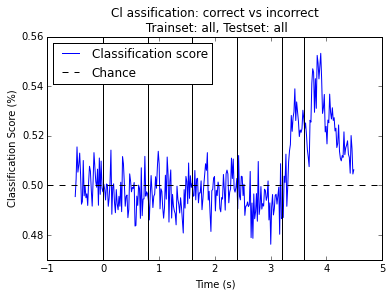

In [69]:
# Plot Diagonal
plt.plot(epochs.times, group_diagonal, label = "Classification score")
plt.axvline(0, color = 'k') #mark stimulus onset
plt.axvline(.8, color = 'k') #mark stimulus onset
plt.axvline(1.6, color = 'k') #mark stimulus onset
plt.axvline(2.4, color = 'k') #mark stimulus onset
plt.axvline(3.2, color = 'k') #mark stimulus onset
plt.axvline(3.6, color = 'k') #mark stimulus onset
plt.axhline(0.5, color = 'k', ls = '--', label = "Chance") #mark chance level
plt.legend(loc = 'upper left')
plt.xlabel('Time (s)')
plt.ylabel('Classification Score (%)')
plt.title('Cl assification: ' + decCond[0] + ' vs ' 
+ decCond[1] + '\n Trainset: ' + trainset + ', Testset: ' + testset)


In [67]:
trialinfo[0][0][0][0][3].T

array([[ 0],
       [33],
       [ 1],
       [ 2],
       [ 3],
       [ 0],
       [33],
       [33],
       [ 1],
       [ 1],
       [ 3],
       [ 0],
       [ 3],
       [ 2],
       [33],
       [ 1],
       [ 3],
       [ 2],
       [33],
       [ 2],
       [ 1],
       [ 2],
       [ 2],
       [ 0],
       [ 3],
       [33],
       [ 0],
       [ 2],
       [33],
       [ 1],
       [ 1],
       [ 3],
       [33],
       [ 1],
       [ 0],
       [ 2],
       [ 1],
       [ 0],
       [33],
       [ 3],
       [ 0],
       [ 3],
       [ 2],
       [ 0],
       [33],
       [33],
       [ 2],
       [33],
       [ 1],
       [ 3],
       [ 2],
       [ 3],
       [ 3],
       [33],
       [ 0],
       [ 0],
       [ 3],
       [ 2],
       [ 1],
       [ 3],
       [ 0],
       [ 2],
       [ 1],
       [33],
       [ 0],
       [ 2],
       [ 2],
       [33],
       [ 3],
       [ 3],
       [ 0],
       [ 0],
       [33],
       [ 0],
       [ 1],
       [ 2],
       [ 1],

In [ ]:
all